# Anisotropic Fast Marching to simulate karst conduit evolution #

Several options for geologic setting:
- simple system with one valley running down center
- two valleys merging into each other
- Gottesacker

<br>C. Fandel 2020.
<br>Library developed by J-M Mirebeau: https://github.com/mirebeau/HamiltonFastMarching
- Documentation & worked examples: https://nbviewer.jupyter.org/github/Mirebeau/AdaptiveGridDiscretizations/blob/master/Notebooks_FMM/Riemannian.ipynb
- Simple conceptual explanations of fast marching approaches: 
   - Isotropic: https://math.berkeley.edu/~sethian/2006/Explanations/fast_marching_explain.html
   - Anisotropic: https://math.berkeley.edu/~sethian/2006/Explanations/ordered_upwind_explain.html

**Installation**
<br>First install the necessary packages.<br>
Clone the AGD repository from GitHub, then create an environment using the environment file: <br>
`conda env create --file agd-hfm.yaml` <br>
    
Or install directly with conda: <br>
`conda install agd -c agd-lbr`

## Imports and functions ##

In [151]:
import agd
from agd import Eikonal
from agd.Metrics import Riemann
from agd.Plotting import quiver
from agd import LinearParallel as lp
from agd import AutomaticDifferentiation as ad
norm_infinity = ad.Optimization.norm_infinity
import sys
import time
import numpy as np
import pandas as pd
import random
import gdal
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mayavi import mlab 
import pyevtk
%matplotlib inline

In [2]:
def crop2topo(grid, dem, a=None, nanval=None):
    '''Crop gempy lith_block to land surface using an imported DEM raster file.
    
    Inputs:
    grid:   list [xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres]
    dem:    array of elevation values, of same xy dimensions as model, to be used for cropping.
    a:      optional: array to be cropped if not using gempy (e.g. as provided by mapping.crop2raster())
            must already be of dimensions (xres,yres,zres)
    nanval: value to use for cells outside of topographic bounds (defaults to np.nan)
              
    Output:
    gcrop:    cropped lith_block array'''

    #Get coordinate info from grid & create VTK cells info in coord system instead of in cell indices:
    xmin = grid[0]   #min (left) coordinate
    xmax = grid[1]   #max (right) coordinate
    xres = grid[2]   #number of pixels
    ymin = grid[3]
    ymax = grid[4]
    yres = grid[5]
    zmin = grid[6]   #important: need zmin of model, NOT just DEM: model may extend below lowest point at land surface
    zmax = grid[7]
    zres = grid[8]
        
    dx   = (xmax-xmin)/xres              #pixel width
    xvals = np.arange(xmin,xmax+dx,dx)   #coordinates of column edges (borders between pixels)
    dy   = (ymax-ymin)/yres
    yvals = np.arange(ymin,ymax+dy,dy)
    dz   = (zmax-zmin)/zres
    zvals = np.arange(zmin,zmax+dz,dz)

    #Get DEM & convert to topo array:
    dema = dem
    dema = dema.astype(float)    #convert integer array to float array
    dema[dema==0] = np.nan       #replace zeros with NaNs (must first convert array to float)        
    t = dema.copy()              #make a copy of elevation values directly from dem (do not use topo grid - different indexing!)

    #Get lith array:
    g = a.copy()                 #use array (make copy) (must already be 3D)
    g = g.round()                #round to integers

    #Check dimensions for debugging:
    #print('topo shape:\t', t.shape)
    #print('lith shape:\t', g.shape)
    #print('topo min:\t',   t.min(), np.unravel_index(t.argmin(), t.shape)) #show indices of min/max of topography
    #print('topo max:\t',   t.max(), np.unravel_index(t.argmax(), t.shape))
    #print('model min:\t',  zmin) #show min/max of entire model
    #print('model max:\t',  zmax)

    #Get z indices of land surface:
    ind = (t - zmin) / dz              #calculate the cell index of each point in the dem array using the cell height (i.e. how many cells/layers up it is from the base)
    #ind = ind - 1                      #bump down by one to represent bottom of cell (this cuts lower than actual topo) 
    ind[ind==-1] = 0                   #zeros should stay zeros and not go negative
    ind = np.ceil(ind)                 #round up to nearest integer 
    ind = ind.astype(int)              #convert to integers for use as vertical indices
    #print('ind:\t', ind.shape, type(ind)) #debugging
    #print(np.unique(ind))

    #Crop off everything above the land surface:
    m = np.zeros((xres,yres))  #create array of zeroes of shape (xres,yres)
    gcrop = g.copy()           #make a copy bc need original as reference
    for x in range(xres):      #loop over x,y indices
        for y in range(yres):
            try:
                z = ind[x,y]            #get land surface elev at point (x,y)
                #m[x,y] = g[x,y,z]       #get lith value at land surface at point (x,y) - only if want to return a map
                if nanval:
                    gcrop[x,y,z:] = nanval  #convert all lith values above land surface at point (x,y) to nanval
                else:
                    gcrop[x,y,z:] = np.nan  #convert all lith values above land surface at point (x,y) to nans
            except:
                z = ind[y,x]
                if nanval:
                    gcrop[x,y,z:] = nanval  #convert all lith values above land surface at point (x,y) to nanval
                else:
                    gcrop[y,x,z:] = np.nan  #convert all lith values above land surface at point (x,y) to nans
    #print('map:\t', m.shape)               #for debugging
    #print('crop:\t', gcrop.shape)
    return gcrop

#################################################################
def export2vtk(sol, vtk_path, a=None):
    '''Export gempy lith_block array to VTK file (for viewing in e.g. ParaView).
    
    Inputs:
    sol:      list of model dimensions [xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres]
    vtk_path: filepath to save VTK file to (must not include any file extension)
    a:        array to export (such as a cropped lith_block)
    
    Returns:
    VTK file representing the exported array'''
    
    #Get coordinate info from grid & create VTK cells info:
    xmin = sol[0]        #min coordinate value (left)
    xmax = sol[1]        #max coordinate value (right)
    xres = sol[2]        #number of pixels
    ymin = sol[3]
    ymax = sol[4]
    yres = sol[5]
    zmin = sol[6]
    zmax = sol[7]
    zres = sol[8]
        
    dx   = (xmax-xmin)/xres                 #pixel width
    xvals = np.arange(xmin,xmax+dx,dx)      #calculate x coordinate values of the boundaries between cells
    dy   = (ymax-ymin)/yres
    yvals = np.arange(ymin,ymax+dy,dy)
    dz   = (zmax-zmin)/zres
    zvals = np.arange(zmin,zmax+dz,dz)

    #Format array for export:
    g = a.copy()                         #make a copy to avoid messing up original

    #Debugging checks:
    #print('x:', xmin,xmax,xres,dx)
    #print('y:', ymin,ymax,yres,dy)
    #print('z:', zmin,zmax,zres,dz)
    #print('shape of array to export:', g.shape)
    #plt.imshow(g[:,:,0])
    
    pyevtk.hl.gridToVTK(vtk_path, xvals, yvals, zvals, cellData={'data': g}) #export to VTK
    
##############################################
def importgslib(filename, grid):
    '''Imports a gslib file (GeoModeller-style) into a numpy array with dimensions taken from a GemPy grid object.
    
    Inputs:
    filename: the name or path to the file to be imported
    grid:     [xres,yres] or [xres,yres,zres]
              
    Returns:
    a:        2D or 3D numpy array representing the gslib data, with dimensions taken from the grid'''
    
    #Get grid info
    xres = grid[0]                          #get x resolution
    yres = grid[1]                          #get y resolution
    if len(grid)==3:                        #if 3D grid
        zres = grid[2]                      #get z resolution
    
    #Get data:
    a = pd.read_csv(filename, skiprows=2, dtype=float)  #read in gslib file to pandas df without header rows, as floats
    a = a.values                                        #get an array of the values
    a[a==0] = np.nan                                    #replace zeros with NaNs (array must be float first)

    #Reshape based on specified grid:
    try:                                             #for 3D files (blocks)
        a = np.reshape(a,(xres,yres,zres),order='F') #reshape to xyz grid using Fortran ordering
        #a = np.rot90(a)                              #rotate 90 degrees CCW
    except:                                          #for 2D files (maps)
        a = np.reshape(a,(xres,yres),order='F')      #reshape to xyz grid using Fortran ordering
        #a = np.rot90(a)                              #rotate 90 degrees CCW
    
    return a

###########################################################
def export2gslib(a, filename, grid):
    '''Exports a numpy array to a gslib file (GeoModeller-style format), using gempy grid objects to get the correct dimensions.
    
    Inputs: 
    a:        numpy array to be exported 
    filename: filename or path to save to
    grid:     [xres,yres,zres]
    
    Output: 
    filename.gslib: a gslib file
    '''
    
    #Format data:
    a[np.isnan(a)] = 0              #assign zeros to nan values (for SKS)
    a = np.round(a)                 #round to integers
    a = a.astype(int)               #convert from floats to integers (so that gslib file will have integers)
    
    #Get grid info
    xres = grid[0]                  #get x resolution
    yres = grid[1]                  #get y resolution
    if len(grid)==3:                #if 3D grid
        zres = grid[2]              #get z resolution
       
    #Format array shape:
    try:                                                #try to reshape in 3D
        a = np.reshape(a,(xres,yres,zres))              #reshape 1D array to a 3D array with correct dimensions
        a = np.reshape(a, xres*yres*zres, order='F')    #reshape 3D array back to 1D array using Fortran indexing 
    except:                                             #if 3D doesn't work, try 2D 
        a = np.reshape(a,(xres,yres))                   #reshape 1D array to a 2D array with correct dimensions
        a = np.reshape(a, xres*yres, order='F')         #reshape 2D array back to 1D array using Fortran indexing 
        
    #Export:    
    df = pd.DataFrame(a)                                #store array in a pandas dataframe
    header = pd.DataFrame(['Geologic model',1,'lith'])  #set gslib file header
    df = header.append(df)                              #attach header and data
    df.to_csv(filename, header=False, index=False)      #write a text file in gslib format

######################################################
def importDEM(filename, show=True):
    '''Import DEM from a tif file using gdal package.
    Return a dem object, and xyz extent and resolution.
    (this can be used to set the model extent)
    NOTE: vertical (z) resolution can't be extracted from the raster!
    
    filename: string indicating the filename (must be a rectangular tif)
    show:     option to show a plot of the DEM or not.
    
    Returns:     grid_info = [xmin,xmax,xres,dx,ymin,ymax,yres,dy,zmin,zmax,zres,dz]  

    dem:      gdal dem objecct
    dema:     array of elevation values of dim: xres,yres
    xmin:     minimum x value (same for ymin, zmin)
    xmax:     maximum x value (same for ymax, zmax)
    xres:     x resolution, aka number of columns, aka number of cells along x axis (NOT pixel width)
    dx:       pixel width in x direction 
    etc.
    '''
    
    dem = gdal.Open(filename)    #DEM must be rectangular tif 
    dema = dem.ReadAsArray()     #copy of DEM as a numpy array (defaults to integers)
    dema = dema.astype(float)    #convert integer array to float array
    dema[dema==0] = np.nan       #replace zeros with NaNs (have to convert array to float first)

    ulx, pixelwidthx, xskew, uly, yskew, pixelheighty = dem.GetGeoTransform() #get resolution and coordinate info (for some reason the order of skew and pixel size is flipped for y axis?!)
    ncol = dem.RasterXSize            #number of columns (aka number of cells along x axis)
    nrow = dem.RasterYSize            #number of rows (aka number of cells along y axis)
    lrx = ulx + (ncol * pixelwidthx)  #lower right x coord = upper left x coord + (width of raster cells in x direction * number of raster cells in x direction)
    lry = uly + (nrow * pixelheighty)

    #Get min and max elevations (z):
    #note: gdal's built-in GetRasterBand and GetStatistics return an incorrect zmin (WHY?!)
    zmin = np.nanmin(dema)
    zmax = np.nanmax(dema)
    
    #Assign useful names:
    xmin = ulx
    xmax = lrx
    xres = ncol
    dx =   abs(pixelwidthx)
    ymin = lry
    ymax = uly
    dy =   abs(pixelheighty)
    yres = nrow
    zres = 'na'     #can't be extracted from raster

    #Print results & display raster:
    if show==True:
        print('Raster dimensions: \nxmin: {:<12} xmax: {:<12} xres: {} \nymin: {:<12} ymax: {:<12} yres: {} \nzmin: {:<12} zmax: {:<12} zres: {}'.format(
            xmin,xmax,xres,ymin,ymax,yres,zmin,zmax,zres))
        plt.imshow(dema, extent=(xmin,xmax,ymin,ymax), vmin=zmin, vmax=zmax) #plot raster as image
        #print(gdal.Info(dem))  #for more detailed file info, uncomment this line
        
    return dem,dema,xmin,xmax,xres,dx,ymin,ymax,yres,dy,zmin,zmax,zres

###############################################
def PointFromIndex(index, dims, origin, scale, to=False):
    '''Turns an index into a point.
    Inputs:
    index:  [ix,iy,iz] index to be converted to point coordinates
    dims:   [xres,yres,zres] number of cells along each axis
    origin: [xmin,ymin,zmin] origin point of grid
    scale:  [dx,dy,dz] the width, height, and depth of each cell or pixel
    to:     True/False, optional. If true, inverse transformation, turning a point into a continuous index
    Outputs:
    point:  [x,y,z] point coordinates corresponding to given index
    '''
    tail = np.asarray((-scale[-1]/2,)*(len(dims)-len(origin)), dtype='float')
    bottom = np.concatenate((origin,tail))
    start = bottom + 0.5*np.asarray(scale)
    index = np.asarray(index, dtype='float')
    #assert index.shape[-1]==self.vdim
    if not to: return start+scale*index      #point from index
    else:      return (index-start)/scale    #index from point
    
###########################
def IndexFromPoint(point, dims, origin, scale, to=True):
    '''Returns the index that yields the position closest to a point, and the error.
    Inputs:
    point: [x,y,z] coordinates to be converted to indices
    dims:   [xres,yres,zres] number of cells along each axis
    origin: [xmin,ymin,zmin] origin point of grid
    scale:  [dx,dy,dz] the width, height, and depth of each cell or pixel
    to:     True/False, optional. If true, inverse transformation, turning a point into a continuous index
    
    Outputs:
    index, error:  [ix,iy,iz], [errorx,errory,errorz]
    '''
    
    point = np.asarray(point, dtype='float')
    continuousIndex = PointFromIndex(point, dims, origin, scale, to=True)
    index = np.round(continuousIndex)
    return index.astype(int),(continuousIndex-index)

#################################
def ss(A, subsampling): 
    '''Get a subsample of points to plot for quiver plots.
    Inputs:
    A: array to subsample
    subsampling: tuple (nx,ny,nz) indicating sampling interval. (5,5,5) would mean sample every fifth point'''
    
    where = tuple(slice(None,None,s) for s in subsampling)
    return A.__getitem__(where)

## Create simple block models for geologic setting ##
There are several geologic units:
- Sandstone (0): brown, high travel cost
- Limestone (1): green, low travel cost
- Shale (2): yellow, high travel cost
- Flysch (3): purple, high travel cost

A single spring drains the system. Inlets (starting points for the conduits to form) are randomly scattered across the limestone unit upgradient of the spring.

Choose only one of these examples to run: <br>
**Example 1:** The layers are tilted and folded into a single central valley draining east. <br>
**Example 2:** Two valleys merge into one. <br>
**Example 3:** Gottesacker



#### Example 1: One valley ####

DEM array: (100, 80) 252.5 600.0
DEM indices: (100, 80) 24 59
Contact surface: (100, 80) 311.0 450.0
Contact indices: (100, 80) 30.0 43.0
Geology array: (100, 80, 60) 2.0 3.0
Cropped geology: (100, 80, 60) 0.0 3.0
Spring indices: [65, 40, 33] Spring coord: [655. 405. 335.]
Spring indices: [60, 50, 37] Spring coord: [605. 505. 375.]
Geologic map: (100, 80) 2.0 3.0


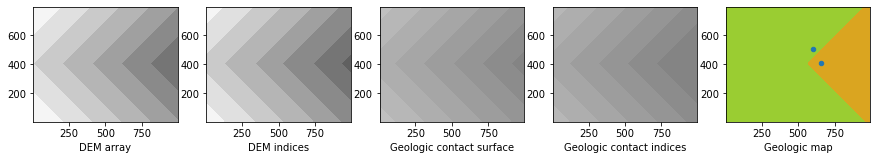

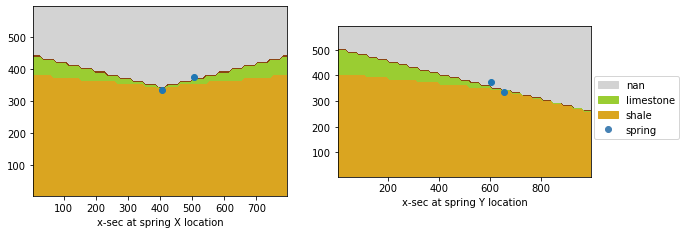

In [132]:
#Create model input object:
hfmIn = Eikonal.dictIn({
    'model':   'Riemann3', #three-dimensional Riemannian eikonal equation (for 2D: Riemann2, for isotropic: Isotropic2 or 3)
    'order':     2
})

#Define grid:
xmin = 0;  xmax = 1000;  xres = 100;  dx = 10.0 
ymin = 0;  ymax = 800;   yres = 80;   dy = 10.0 
zmin = 0;  zmax = 600;   zres = 60;   dz = 10.0

# Define grid for the model object:
hfmIn.SetRect(sides=[[xmin,xmax],[ymin,ymax],[zmin,zmax]],dims=[xres,yres,zres])
X,Y,Z = hfmIn.Grid()  #get model grid

#Create topography array:
dema = np.full((xres,yres),zmax, dtype=float) #create array with the model x and y dimensions, filled with the max z index
mx = -0.25 * dx                     #set the slope in the x direction (west to east)
my = -0.25 * dy                     #set the slope in the y direction (north to south)
valley  = yres//2                   #set which row to put the valley in
for ix in range(xres):                 #move west to east along x indices (columns)
    dema[ix,:] = mx*ix + dema[0,0]     #change the elevation in each column along a slope, starting from the max elevation
    for iy in range(0,valley+1):       #move down rows towards valley (north to south)
        dema[ix,iy] = my*iy + dema[ix,0]    #change the elevation in each row along a slope, starting from the elevation along the northern edge
for iy in range(valley,yres):               #move down y indices (rows) away from valley (south to north)
    dema[:,iy] = dema[:,yres-iy]            #insert a mirror image of the north side of the valley
f = plt.figure(figsize=(15,5))
f.add_subplot(151, aspect='equal')
plt.contourf(X[:,:,0],Y[:,:,0], dema, cmap='gray', vmin=zmin,vmax=zmax) #darker=lower (don't use imshow because indexing is different)
plt.xlabel('DEM array')
print('DEM array:', dema.shape, dema.min(), dema.max())

#Convert from elevations to z cell indices:
idem = np.full((xres,yres), zres, dtype=int)    #create an array with model x and y dimensions, filled with max z index
for iy in range(yres):
    for ix,z in enumerate(dema[:,iy]):
        #[[xind,yind,zind],error] = IndexFromPoint([0,0,z], [xres,yres,zres], [xmin,ymin,zmin], [dx,dy,dz]) #use new fn
        [[xind,yind,zind],error] = hfmIn.IndexFromPoint([0,0,z])   #use built-in
        idem[ix,iy] = zind-1 #correct to be index below
f.add_subplot(152, aspect='equal')
plt.contourf(X[:,:,0],Y[:,:,0], idem, cmap='gray', vmin=0,vmax=zres)  #0=bottom,black, 1=top,white
plt.xlabel('DEM indices')
print('DEM indices:', idem.shape, idem.min(), idem.max())

#Create geologic contact surface elevation array:
zstart = zmax - (zmax-zmin)//4
zcontact = np.full((xres,yres), zstart, dtype=float) #create array with the model x and y dimensions, filled with the max z value
mx = -0.1 * dx                 #set the slope in the x direction (west to east)
my = -0.1 * dy                 #set the slope in the y direction (north to south)
valley  = yres//2              #set which row to put the valley in
for ix in range(xres):                        #move west to east along columns
    zcontact[ix,:] = mx*ix + zcontact[0,0]    #change the elevation in each column along a slope, starting from the max elevation
    for iy in range(ymin,valley+1):           #move down rows towards valley (north to south)
        zcontact[ix,iy] = my*iy + zcontact[ix,0]   #change the elevation in each row along a slope, starting from the elevation along the northern edge
for iy in range(valley,yres):                      #move down rows away from valley (south to north)
    zcontact[:,iy] = zcontact[:,yres-iy]           #insert a mirror image of the north side of the valley
f.add_subplot(153, aspect='equal')
plt.contourf(X[:,:,0],Y[:,:,0], zcontact, cmap='gray', vmin=zmin,vmax=zmax)  
plt.xlabel('Geologic contact surface')
print('Contact surface:', zcontact.shape, zcontact.min(), zcontact.max())

#Convert from elevations to cell z indices:
icontact = np.empty((xres,yres))
for iy in range(yres):
    for ix,z in enumerate(zcontact[:,iy]):
        #[[xind,yind,zind],error] = IndexFromPoint([0,0,z], [xres,yres,zres], [xmin,ymin,zmin], [dx,dy,dz])
        [[xind,yind,zind],error] = hfmIn.IndexFromPoint([0,0,z])
        icontact[ix,iy] = zind - 1
f.add_subplot(154, aspect='equal')
plt.contourf(X[:,:,0],Y[:,:,0], icontact, cmap='gray', vmin=0,vmax=zres)  
plt.xlabel('Geologic contact indices')
print('Contact indices:', icontact.shape, icontact.min(), icontact.max())

#Create 3D geology array (the integer in each cell indicates the formation present in that cell):
geo = np.empty((xres,yres,zres))   #set empty 3D array of model dimensions
for ix in range(xres):            #loop over cols, rows, & layers
    for iy in range(yres):
        for iz in range(zres):             #for each cell, 
            if iz <= icontact[ix,iy]:    #if layer is below the contact index (i.e. has a lower index),
                geo[ix,iy,iz] = 3        #assign 3 for shale
            if iz > icontact[ix,iy]:     #if layer is above the contact index (i.e. has a higher index),
                geo[ix,iy,iz] = 2        #assign 2 for limestone
#export2vtk([xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres], 'geo', a=geo) #uncomment to export for ParaView
print('Geology array:', geo.shape, geo.min(), geo.max())    
    
#Crop & export geology array:
geocrop  = crop2topo([xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres], dema, geo)   #crop to land surface (only works if the xy resolution of the DEM is the same as the xy resolution of the model)
export2vtk([xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres], 'geocrop', a=geocrop)  #uncomment to export for ParaView
export2gslib(geocrop, 'geocrop.gslib', [xres,yres,zres])                            #export to GSLIB for SKS
print('Cropped geology:', geocrop.shape, geocrop.min(), geocrop.max() )

#Create geologic map
geomap = np.empty((xres,yres))      #set empty 2D array of model dimensions
for ix in range(xres):             #loop over cols, rows
    for iy in range(yres):
        iz = idem[ix,iy]                 #get layer index of land surface at current cell
        geomap[ix,iy] = geo[ix,iy,iz]  #assign map value to be geologic formation present at current cell at land surface

#Define spring locations:
springixiy = [[65,40], [60,50]]              #[[ix1,iy1],[ix2,ix2],... ] X and Y indices of springs
isprings   = []     
springs    = []
for ispring in springixiy:
    zspring = idem[ispring[0],ispring[1]]      #get surface elevation index of spring from topo array
    ispring.append(int(zspring)+1)             #store spring index moved up by one to be above land surface
    springXYZ = hfmIn.PointFromIndex([ispring[0],ispring[1],ispring[2]])  #convert to coordinates
    print('Spring indices:',ispring, 'Spring coord:', springXYZ)
    isprings.append(ispring)
    springs.append(springXYZ)                       #store
isprings = np.array(isprings)
springs = np.array(springs)                         #convert to array
springdf = pd.DataFrame(springs,index=np.arange(len(springs)), columns=['x','y','z'])  #convert to df for easier export
springdf.to_csv('springs.csv',header=True,index=False)                                 #export to csv for viewing in ParaView
xsec = isprings[isprings[:,2]==np.min(isprings[:,2])][0]  #get lowest spring coordinates to slice at for plots

#Plot geologic map:
cmap = matplotlib.colors.ListedColormap(['lightgray','saddlebrown','yellowgreen','goldenrod','purple','k']) #create custom colormap
                                         #0:nan      #1:sandstone  #2:limestone  #3:shale    #4:flysch
f.add_subplot(155, aspect='equal')
plt.contourf(X[:,:,0],Y[:,:,0], geomap, cmap=cmap, vmin=0,vmax=5)  
plt.scatter(springs[:,0], springs[:,1], s=20)    #show spring location
plt.xlabel('Geologic map')
print('Geologic map:', geomap.shape, geomap.min(), geomap.max())

#Plot sliced views of geology array:
f,ax = plt.subplots(1,2, figsize=(10,5), subplot_kw={'aspect':'equal'})
ax[0].contourf(Y[0,:,:],Z[0,:,:], geocrop[xsec[0],:,:], cmap=cmap, vmin=0,vmax=5)     
ax[0].scatter(springs[:,1],springs[:,2])  #spring 
ax[0].set_xlabel('x-sec at spring X location')
ax[1].contourf(X[:,0,:],Z[:,0,:], geocrop[:,xsec[1],:], cmap=cmap, vmin=0,vmax=5)
ax[1].scatter(springs[:,0],springs[:,2]) #spring
ax[1].set_xlabel('x-sec at spring Y location')
ax[1].legend((matplotlib.patches.Patch(color='lightgray'),
              matplotlib.patches.Patch(color='yellowgreen'),
              matplotlib.patches.Patch(color='goldenrod'), 
              matplotlib.lines.Line2D([0],[0], marker='o', color='steelblue', linestyle='None')),
             ('nan', 'limestone', 'shale', 'spring'),
              loc=(1.01,0.25))

#### Example 2: Two valleys ####

DEM array: (100, 80) 252.5 600.0
DEM indices: (100, 80) 24 59
Contact surface: (100, 80) 276.25 450.0
Contact indices: (100, 80) 26.0 43.0
Geology array: (100, 80, 60) 2.0 3.0
Cropped geology: (100, 80, 60) 0.0 3.0
Spring indices: [90, 40, 27] Spring coord: [905. 405. 275.]
Spring indices: [60, 50, 37] Spring coord: [605. 505. 375.]
Geologic map: (100, 80) 2.0 3.0


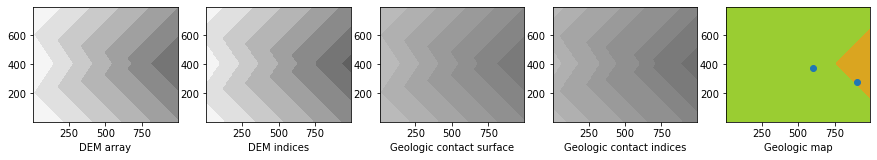

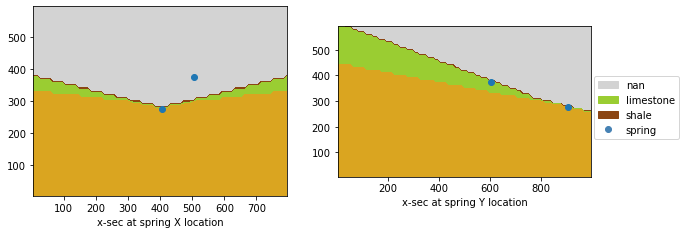

In [134]:
#Create model input object:
hfmIn = Eikonal.dictIn({
    'model':   'Riemann3', #three-dimensional Riemannian eikonal equation (for 2D: Riemann2, for isotropic: Isotropic2 or 3)
    'order':     2
})

#Define grid:
xmin = 0;  xmax = 1000;  xres = 100;  dx = 10.0 
ymin = 0;  ymax = 800;   yres = 80;   dy = 10.0 
zmin = 0;  zmax = 600;   zres = 60;   dz = 10.0

# Define grid for the model object:
hfmIn.SetRect(sides=[[xmin,xmax],[ymin,ymax],[zmin,zmax]],dims=[xres,yres,zres])
X,Y,Z = hfmIn.Grid()  #get model grid

#Create topography array:
dema = np.full((xres,yres),zmax, dtype=float) #create array with the model x and y dimensions, filled with the max z index
mx = -0.25 * dx                     #set the slope in the x direction (west to east)
my = -0.25 * dy                     #set the slope in the y direction (north to south)
center   = yres // 2                #set centerline between valleys
merge    = xres - xres//4           #set merge point of two valleys
valley1  = np.round(np.linspace(yres//4,       center,merge)).astype(int) #set array of valley1 y indices
valley1 = np.append(valley1, np.full(xres-merge, valley1[-1]))
valley2  = np.round(np.linspace(yres - yres//4,center,merge)).astype(int) #set array of valley2 y indices
valley2 = np.append(valley2, np.full(xres-merge, valley2[-1]))

for ix in range(xres):                 #move west to east along x indices (columns)
    dema[ix,:] = mx*ix + dema[0,0]     #change the elevation in each column along a slope, starting from the max elevation
    for iy in range(0,valley1[ix]+1):       #move up rows towards valley 1 (south to north)
        dema[ix,iy] = my*iy + dema[ix,0]    #change the elevation in each row along a slope, starting from the elevation along the northern edge
    for iy in range(yres-1, valley2[ix]-1, -1):  #move down rows towards valley 2 (north to south)
        dema[ix,iy] = dema[ix,yres-iy]           #insert a mirror image of the south side of the first valley
    if ix < merge:
        for iy in range(valley1[ix],center+1):             #move up y indices (rows) away from valley (south to north)
            dema[ix,iy] = 0.5*mx*ix + dema[ix,center-iy]   #insert upward slope towards centerline
        for iy in range(valley2[ix],center, -1):           #move down y indices (rows) away from valley (north to south)
            dema[ix,iy] = dema[ix,yres-iy]                 #insert a mirror image of the south side of the valley  
        
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(151, aspect='equal')
c = plt.contourf(X[:,:,0],Y[:,:,0], dema, cmap='gray', vmin=zmin,vmax=zmax) #darker=lower (don't use imshow because indexing is different)
plt.xlabel('DEM array')
#plt.colorbar(c, ax=ax, shrink=0.35, aspect=10)
print('DEM array:', dema.shape, dema.min(), dema.max())

#Convert from elevations to z cell indices:
idem = np.full((xres,yres), zres, dtype=int)    #create an array with model x and y dimensions, filled with max z index
for iy in range(yres):
    for ix,z in enumerate(dema[:,iy]):
        #[[xind,yind,zind],error] = IndexFromPoint([0,0,z], [xres,yres,zres], [xmin,ymin,zmin], [dx,dy,dz]) #use new fn
        [[xind,yind,zind],error] = hfmIn.IndexFromPoint([0,0,z])   #use built-in
        idem[ix,iy] = zind-1 #correct to be index below
f.add_subplot(152, aspect='equal')
plt.contourf(X[:,:,0],Y[:,:,0], idem, cmap='gray', vmin=0,vmax=zres)  #0=bottom,black, 1=top,white
plt.xlabel('DEM indices')
print('DEM indices:', idem.shape, idem.min(), idem.max())

#Create geologic contact surface elevation array:
zstart = zmax - (zmax-zmin)//4
zcontact = np.full((xres,yres), zstart, dtype=float) #create array with the model x and y dimensions, filled with the max z value
mx = -0.125 * dx                     #set the slope in the x direction (west to east)
my = -0.125 * dy                     #set the slope in the y direction (north to south)
center   = yres // 2                #set centerline between valleys
merge    = xres - xres//4           #set merge point of two valleys
valley1  = np.round(np.linspace(yres//4,       center,merge)).astype(int) #set array of valley1 y indices
valley1 = np.append(valley1, np.full(xres-merge, valley1[-1]))
valley2  = np.round(np.linspace(yres - yres//4,center,merge)).astype(int) #set array of valley2 y indices
valley2 = np.append(valley2, np.full(xres-merge, valley2[-1]))

for ix in range(xres):                 #move west to east along x indices (columns)
    zcontact[ix,:] = mx*ix + zcontact[0,0]     #change the elevation in each column along a slope, starting from the max elevation
    for iy in range(0,valley1[ix]+1):       #move up rows towards valley 1 (south to north)
        zcontact[ix,iy] = my*iy + zcontact[ix,0]    #change the elevation in each row along a slope, starting from the elevation along the northern edge
    for iy in range(yres-1, valley2[ix]-1, -1):  #move down rows towards valley 2 (north to south)
        zcontact[ix,iy] = zcontact[ix,yres-iy]           #insert a mirror image of the south side of the first valley
    if ix < merge:
        for iy in range(valley1[ix],center+1):             #move up y indices (rows) away from valley (south to north)
            zcontact[ix,iy] = 0.5*mx*ix + zcontact[ix,center-iy]   #insert upward slope towards centerline
        for iy in range(valley2[ix],center, -1):           #move down y indices (rows) away from valley (north to south)
            zcontact[ix,iy] = zcontact[ix,yres-iy]                 #insert a mirror image of the south side of the valley  

f.add_subplot(153, aspect='equal')
plt.contourf(X[:,:,0],Y[:,:,0], zcontact, cmap='gray', vmin=zmin,vmax=zmax)  
plt.xlabel('Geologic contact surface')
print('Contact surface:', zcontact.shape, zcontact.min(), zcontact.max())

#Convert from elevations to cell z indices:
icontact = np.empty((xres,yres))
for iy in range(yres):
    for ix,z in enumerate(zcontact[:,iy]):
        #[[xind,yind,zind],error] = IndexFromPoint([0,0,z], [xres,yres,zres], [xmin,ymin,zmin], [dx,dy,dz])
        [[xind,yind,zind],error] = hfmIn.IndexFromPoint([0,0,z])
        icontact[ix,iy] = zind - 1
f.add_subplot(154, aspect='equal')
plt.contourf(X[:,:,0],Y[:,:,0], icontact, cmap='gray', vmin=0,vmax=zres)  
plt.xlabel('Geologic contact indices')
print('Contact indices:', icontact.shape, icontact.min(), icontact.max())

#Create 3D geology array (the integer in each cell indicates the formation present in that cell):
#Important: layer 0 is at the top, layer 60 is at the bottom (NOT vice-versa)
geo = np.empty((xres,yres,zres))   #set empty 3D array of model dimensions
for ix in range(xres):            #loop over cols, rows, & layers
    for iy in range(yres):
        for iz in range(zres):             #for each cell, 
            if iz <= icontact[ix,iy]:    #if layer is below the contact index (i.e. has a lower index),
                geo[ix,iy,iz] = 3        #assign 3 for shale
            if iz > icontact[ix,iy]:     #if layer is above the contact index (i.e. has a higher index),
                geo[ix,iy,iz] = 2        #assign 2 for limestone
#export2vtk([xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres], 'geo', a=geo) #uncomment to export for ParaView
print('Geology array:', geo.shape, geo.min(), geo.max())    

#Crop & export geology array:
geocrop  = crop2topo([xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres], dema, geo)   #crop to land surface (only works if the xy resolution of the DEM is the same as the xy resolution of the model)
export2vtk([xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres], 'geocrop', a=geocrop)  #uncomment to export for ParaView
export2gslib(geocrop, 'geocrop.gslib', [xres,yres,zres])                            #export to GSLIB for SKS
print('Cropped geology:', geocrop.shape, geocrop.min(), geocrop.max() )

#Create geologic map
geomap = np.empty((xres,yres))      #set empty 2D array of model dimensions
for ix in range(xres):             #loop over cols, rows
    for iy in range(yres):
        iz = idem[ix,iy]                 #get layer index of land surface at current cell
        geomap[ix,iy] = geo[ix,iy,iz]  #assign map value to be geologic formation present at current cell at land surface

#Define spring location:
springixiy = [[90,40], [60,50]]              #[[ix1,iy1],[ix2,ix2],... ]
isprings   = []
springs    = []
for ispring in springixiy:
    zspring = idem[ispring[0],ispring[1]]      #get surface elevation index of spring from topo array
    ispring.append(int(zspring)+1)            #store spring index moved up by one to be above land surface
    springXYZ = hfmIn.PointFromIndex([ispring[0],ispring[1],ispring[2]])  #convert to coordinates
    print('Spring indices:',ispring, 'Spring coord:', springXYZ)
    isprings.append(ispring)
    springs.append(springXYZ)                       #store
isprings = np.array(isprings)
springs = np.array(springs)                         #convert to array
springdf = pd.DataFrame(springs,index=np.arange(len(springs)), columns=['x','y','z'])  #convert to df for easier export
springdf.to_csv('springs.csv',header=True,index=False)                                 #export to csv for viewing in ParaView
xsec = isprings[isprings[:,2]==np.min(isprings[:,2])][0]  #get lowest spring coordinates to slice at for plots

#Plot geologic map:
cmap = matplotlib.colors.ListedColormap(['lightgray','saddlebrown','yellowgreen','goldenrod','purple','k']) #create custom colormap
                                         #0:nan      #1:sandstone  #2:limestone  #3:shale    #4:flysch
f.add_subplot(155, aspect='equal')
plt.contourf(X[:,:,0],Y[:,:,0], geomap, cmap=cmap, vmin=0,vmax=5)   
plt.scatter(springs[:,0],springs[:,2]) #spring
plt.xlabel('Geologic map')
print('Geologic map:', geomap.shape, geomap.min(), geomap.max())

#Plot sliced views of geologic map:
f,ax = plt.subplots(1,2, figsize=(10,5), subplot_kw={'aspect':'equal'})
ax[0].contourf(Y[0,:,:],Z[0,:,:], geocrop[xsec[0],:,:], cmap=cmap, vmin=0,vmax=5)   
ax[0].scatter(springs[:,1],springs[:,2])  #spring 
ax[0].set_xlabel('x-sec at spring X location')
ax[1].contourf(X[:,0,:],Z[:,0,:], geocrop[:,xsec[1],:], cmap=cmap, vmin=0,vmax=5)
ax[1].scatter(springs[:,0],springs[:,2]) #spring
ax[1].set_xlabel('x-sec at spring Y location')
ax[1].legend((matplotlib.patches.Patch(color='lightgray'),
              matplotlib.patches.Patch(color='yellowgreen'),
              matplotlib.patches.Patch(color='saddlebrown'), 
              matplotlib.lines.Line2D([0],[0], marker='o', color='steelblue', linestyle='None')),
             ('nan', 'limestone', 'shale', 'spring'),
              loc=(1.01,0.25))

#### Example 3: Gottesacker ####

Grid dimensions: 
xmin: 578287.5     xmax: 590837.5     xres: 251          dx: 50.0 
ymin: 5240062.5    ymax: 5250062.5    yres: 200          dy: 50.0 
zmin: 800          zmax: 2230.0       zres: 52           dz: 27.5
DEM array: (251, 200) 913.0 2230.0
DEM indices: (251, 200) 3 51
Geology array (cropped to topo): (251, 200, 52) 1.0 4.0
Values: [1. 2. 3. 4.]
Formations: sandstone, limestone, shale, flysch
Geologic map: (251, 200) 1.0 4.0
Spring indices: [189  98  11] Spring coord: [5.87747520e+05 5.24496363e+06 1.12000000e+03]
Spring indices: [196 111  10] Spring coord: [5.88123610e+05 5.24563824e+06 1.08000000e+03]
Spring indices: [213 133   8] Spring coord: [5.88979500e+05 5.24673086e+06 1.03500000e+03]


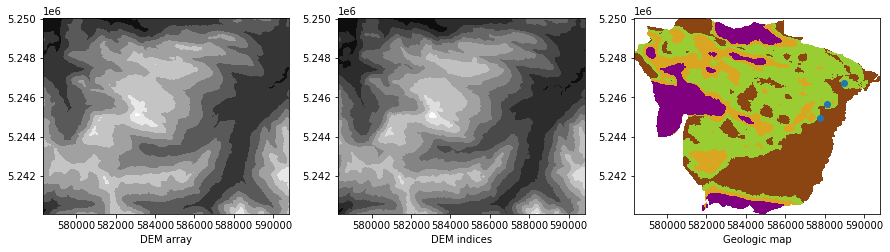

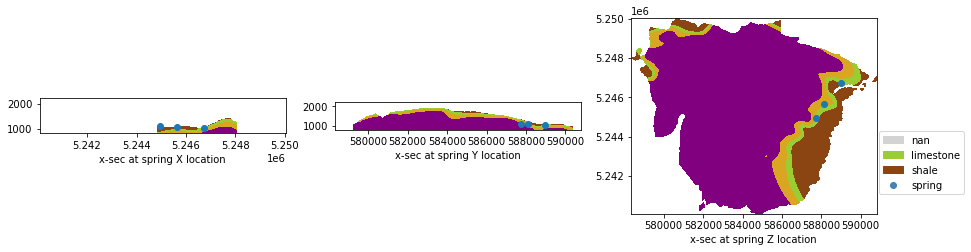

In [164]:
#Create model input object:
hfmIn = Eikonal.dictIn({
    'model':   'Riemann3', #three-dimensional Riemannian eikonal equation (for 2D: Riemann2, for isotropic: Isotropic2 or 3)
    'order':     2
})

#Get and assign model grid and resolution automatically based on DEM raster file:
dem_path = 'DEMraster50_251x200.tif'   #path to DEM raster file to import
dem,dema,xmin,xmax,xres,dx,ymin,ymax,yres,dy,zmin,zmax,zres = importDEM(dem_path,show=False) 
dema = np.rot90(dema, k=-1) #rotate DEM array 90 degrees to resolve column indexing issues
zmin = 800                  #manually set zmin so that model extends below land surface - must be integer
zres = 52                   #set vertical (z) resolution (number of layers)  (this has nothing to do with dem resolution)
dz = (zmax-zmin)/zres       #calculate z cell height (kind of like contour interval)
print('Grid dimensions: \nxmin: {:<12} xmax: {:<12} xres: {:<12} dx: {} \nymin: {:<12} ymax: {:<12} yres: {:<12} dy: {} \nzmin: {:<12} zmax: {:<12} zres: {:<12} dz: {}'.format(
        xmin,xmax,xres,dx, ymin,ymax,yres,dy, zmin,zmax,zres,dz))

# Define grid for the model object:
hfmIn.SetRect(sides=[[xmin,xmax],[ymin,ymax],[zmin,zmax]],dims=[xres,yres,zres])
X,Y,Z = hfmIn.Grid()  #get model grid

#Plot topography:
f = plt.figure(figsize=(15,5))
f.add_subplot(131, aspect='equal')
plt.contourf(X[:,:,0],Y[:,:,0], dema, cmap='gray', vmin=zmin,vmax=zmax) #darker=lower (don't use imshow because indexing is different)
plt.xlabel('DEM array')
print('DEM array:', dema.shape, dema.min(), dema.max())

#Convert from elevations to z cell indices:
idem = np.full((xres,yres), zres, dtype=int)    #create an array with model x and y dimensions, filled with max z index
for iy in range(yres):
    for ix,z in enumerate(dema[:,iy]):
        #[[xind,yind,zind],error] = IndexFromPoint([0,0,z], [xres,yres,zres], [xmin,ymin,zmin], [dx,dy,dz]) #use new fn
        [[xind,yind,zind],error] = hfmIn.IndexFromPoint([0,0,z])   #use built-in
        idem[ix,iy] = zind-1 #correct to be index below
f.add_subplot(132, aspect='equal')
plt.contourf(X[:,:,0],Y[:,:,0], idem, cmap='gray', vmin=0,vmax=zres)  #0=bottom,black, 1=top,white
plt.xlabel('DEM indices')
print('DEM indices:', idem.shape, idem.min(), idem.max())

#Import 3D geology array (the integer in each cell indicates the formation present in that cell):
geo_path = 'testgp01020geo.gslib'              #path to GSLIB file for geologic model
geocrop = importgslib(geo_path, [xres,yres,zres])  #import geologic model from GSLIB file
print('Geology array (cropped to topo):', geocrop.shape, np.nanmin(geocrop), np.nanmax(geocrop)) 
print('Values:', np.unique(geocrop[~np.isnan(geocrop)]))
print('Formations:', 'sandstone, limestone, shale, flysch')
export2vtk([xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres], 'geocrop', a=geocrop)  #uncomment to export for ParaView

#Create geologic map
geomap = np.empty((xres,yres))      #set empty 2D array of model dimensions
for ix in range(xres):             #loop over cols, rows
    for iy in range(yres):
        iz = idem[ix,iy]                 #get layer index of land surface at current cell
        geomap[ix,iy] = geocrop[ix,iy,iz]  #assign map value to be geologic formation present at current cell at land surface

#Plot geologic map:
cmap = matplotlib.colors.ListedColormap(['lightgray','saddlebrown','yellowgreen','goldenrod','purple','k']) #create custom colormap
f.add_subplot(133, aspect='equal')
plt.contourf(X[:,:,0],Y[:,:,0], geomap, cmap=cmap, vmin=0,vmax=5)   #0:nan, gray, 1: limestone, green 2: shale, brown  
plt.xlabel('Geologic map')
print('Geologic map:', geomap.shape, np.nanmin(geomap), np.nanmax(geomap))

#Define spring location:
shuffle = True                                     #True: shuffle order springs will be run to add variability
springs = pd.read_csv('springXYZinput.txt', delimiter=',', names=['X','Y','Z'], dtype='float') #import spring coord from file
#springs = springs.iloc[2]                         #uncomment to pick only the lowest spring to test
springs = np.array(springs)                        #convert to array
isprings = []
for spring in springs:                             #loop over springs
    ispring,error = hfmIn.IndexFromPoint(spring)   #get indices for spring
    print('Spring indices:',ispring, 'Spring coord:', spring)
    isprings.append(ispring)
isprings = np.array(isprings)
if shuffle == True:
    np.random.shuffle(springs)                     #shuffle order 
springsdf = pd.DataFrame(springs,index=np.arange(len(springs)), columns=['x','y','z'])  #convert to df for easier export
springsdf.to_csv('springs.csv',header=True,index=False)    #export to csv for viewing in ParaView
xsec = isprings[isprings[:,2]==np.min(isprings[:,2])][0]   #get lowest spring coordinates to slice at for plots
plt.scatter(springs[:,0],springs[:,1])                     #plot on geologic map

#Plot sliced views of geologic map:
f,ax = plt.subplots(1,3, figsize=(15,5), subplot_kw={'aspect':'equal'})
ax[0].contourf(Y[0,:,:],Z[0,:,:], geocrop[xsec[0],:,:], cmap=cmap, vmin=0,vmax=5)   #0:nan, gray, 1: limestone, green 2: shale, brown  
ax[0].scatter(springs[:,1],springs[:,2])  #spring 
ax[0].set_xlabel('x-sec at spring X location')
ax[1].contourf(X[:,0,:],Z[:,0,:], geocrop[:,xsec[1],:], cmap=cmap, vmin=0,vmax=5)
ax[1].scatter(springs[:,0],springs[:,2]) #spring
ax[1].set_xlabel('x-sec at spring Y location')
ax[2].contourf(X[:,:,0],Y[:,:,0], geocrop[:,:,xsec[2]], cmap=cmap, vmin=0,vmax=5)
ax[2].scatter(springs[:,0],springs[:,1]) #spring
ax[2].set_xlabel('x-sec at spring Z location')
ax[2].legend((matplotlib.patches.Patch(color='lightgray'),
              matplotlib.patches.Patch(color='yellowgreen'),
              matplotlib.patches.Patch(color='saddlebrown'), 
              matplotlib.lines.Line2D([0],[0], marker='o', color='steelblue', linestyle='None')),
             ('nan', 'limestone', 'shale', 'spring'),
              loc=(1.01,0.1))

Cropped cost array: (251, 200, 52) 20.0 99.9 [20.  60.  99.9]
Rescaled cost values: [0.2   0.6   0.999]


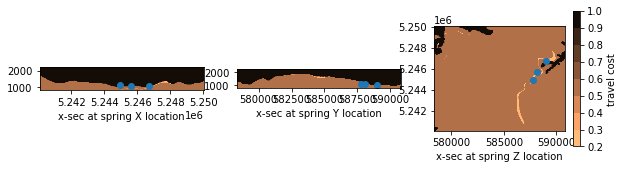

In [165]:
#Define simple fractures (optional):
fractures = np.zeros(geocrop.shape)
runFrac = False
if runFrac:
    fractures[25:60, 30, 0:50] = 1   #assign ones to cells with fractures present
    fractures[15:55, 45, 0:50] = 1

#Define simple obstacles (optional):
obstacles = np.zeros(geocrop.shape)
runObstacles = False
if runObstacles:
    obstacles[25:35, 35:45, :] = 1   #assign ones to cells with obstacles present

#Define overall cost array:
#Note: for some reason this only works if values are >=1.
#To get around this,the fractional cost values listed will be multiplied by 100 to create the array
#Then the entire array is divided by 100 to get back to the original values between 0 and 1
Cout      = 0.999  #travel cost in areas outside model bound (should be very high)
Ckarst    = 0.2    #travel cost in karstifiable unit (should be low)
Cnonkarst = 0.6    #travel cost in nonkarst unit (should be high)
Cfracture = 0.05   #travel cost in fractures
Cconduit  = 0.1   #travel cost in conduits (should be low)
Cobstacle = 0.8    #travel cost through obstacles (should be high)

cost = np.full(geocrop.shape, Ckarst*100)    #set up array of default alpha values
cost[geocrop==2]        = Ckarst*100     #assign low cost to limestone (2)
cost[geocrop!=2]        = Cnonkarst*100  #assign medium-high cost to all non-karst units
cost[fractures==1]      = Cfracture*100  #assign lower cost to fractures 
cost[obstacles==1]      = Cobstacle*100  #assign high cost to obstacles

#Crop, export, & rescale cost array:
cost  = crop2topo([xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres], dema, cost, Cout*100)   #crop to land surface (only works if the xy resolution of the DEM is the same as the xy resolution of the model)
export2vtk([xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres], 'cost', a=cost)  #uncomment to export for ParaView
export2gslib(cost, 'cost.gslib', [xres,yres,zres])                            #export to GSLIB for SKS
print('Cropped cost array:', cost.shape, cost.min(), cost.max(), np.unique(cost) )
cost = cost / 100                   #divide by same multiplier as above to fit between 0 and 1
print('Rescaled cost values:', np.unique(cost))

#Plot sliced views of cost array:
f,ax = plt.subplots(1,3, figsize=(10,5), subplot_kw={'aspect':'equal'})
c = ax[0].contourf(Y[0,:,:],Z[0,:,:], cost[xsec[0],:,:], cmap='copper_r')   #0:nan, gray, 1: limestone, green 2: shale, brown  
ax[0].scatter(springs[:,1],springs[:,2])  #spring 
ax[0].set_xlabel('x-sec at spring X location')
ax[1].contourf(X[:,0,:],Z[:,0,:], cost[:,xsec[1],:], cmap='copper_r')
ax[1].scatter(springs[:,0],springs[:,2]) #spring
ax[1].set_xlabel('x-sec at spring Y location')
ax[2].contourf(X[:,:,0],Y[:,:,0], cost[:,:,xsec[2]], cmap='copper_r')
ax[2].scatter(springs[:,0],springs[:,1]) #spring
ax[2].set_xlabel('x-sec at spring Z location')
plt.colorbar(c, ax=ax[2], shrink=0.5, aspect=20, orientation='vertical', label='travel cost')

#### TO-DO #### 
- [X] multiple springs
    - [X] add option to shuffle spring order
- [ ] import gradient field from GemPy
- [ ] define water table surface
- [ ] two-stage conduit generation: unsaturated, then saturated
- [X] randomly generate inlets only from areas upstream of springs
    - [X] add option to shuffle inlet order

loading starting points
calculating elevations
tips:
 [[5.84054440e+05 5.24705664e+06 1.74875000e+03]
 [5.82880850e+05 5.24305512e+06 1.41875000e+03]
 [5.83363180e+05 5.24591793e+06 1.94125000e+03]
 [5.81536590e+05 5.24459962e+06 1.85875000e+03]
 [5.85367030e+05 5.24815177e+06 1.66625000e+03]]


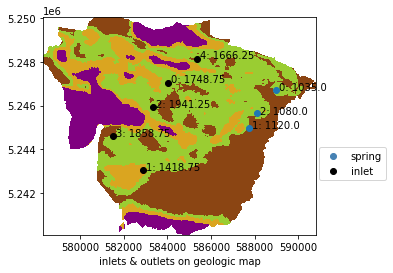

In [166]:
#Generate the inlets (starting points for the walker path calculations):
generate = False      #True: generate random xy starting points. False: load existing from file
shuffle  = True       #True: shuffle order randomly each run to add variability to the resulting networks
elev     = 'top'      #'top': start at land surface. 'bottom': start at bottom of karst 
if generate: 
    print('generating new starting points')
    ntips = 3                                        #number of start points to generate
    #Create array of possible tip locations (above spring elevation):
    tipzone = geocrop.copy()                         #make a copy to avoid messing up original
    tipzone[tipzone!=2] = np.nan                     #assign nans to all non-karst values
    tipzone[dema <= springXYZ[2],:] = np.nan         #assign nans to all cells below spring elevation
    ind = np.where(np.isfinite(tipzone).ravel())[0]  #get 2D vector of indices for all non-nan cells
    tipind = np.random.permutation(ind)[:ntips]      #shuffle and randomly choose some number of indices
    tipind = np.asarray(np.unravel_index(tipind, tipzone.shape)) #unravel back to 3 x ntips index array
    #Generate tips:    
    tips = []
    for i in range(ntips):                         #loop over points to get coordinates
        [x,y,z] = PointFromIndex([tipind[0,i],tipind[1,i],tipind[2,i]], [xres,yres,zres], [xmin,ymin,zmin], [dx,dy,dz])  #convert indices to coordinates with dummy z
        tips.append([x,y,z])                       #store
    tips = np.array(tips)                          #convert to array

else:
    print('loading starting points')
    #tips = pd.read_csv('tips.csv').values          #for saved tips from previous auto-generation: load tips from csv and convert to array   
    tips = pd.read_csv('tipsinput.csv').values    #for tips manually created as text file (for Gottesacker): load tips from csv and convert to array       
    
print('calculating elevations')
for i in range(len(tips)):
    x = tips[i,0]                              #get x coord
    y = tips[i,1]                              #get y coord
    [ix,iy,iz],error = IndexFromPoint([x,y,0], [xres,yres,zres], [xmin,ymin,zmin], [dx,dy,dz]) #convert to indices with dummy z values
    if elev=='top':
        iz = idem[ix,iy]                      #get land surface index
    if elev=='bottom':
        iz = ispring[2]                       #get spring z elevation to start at water table
        #print('starting index', col,row,lay, 'unit', geo[col,row,lay])
        while geocrop[ix,iy,iz] > 2:      #if the point is below the karst unit (karst=2, unit numbers increase going down)
            iz = iz + 1               #move up by one (0 is bottom?)
            #print('point is below karst unit - move index up one', col,row,lay, 'unit', geo[col,row,lay])
            if iz > zres:             #if exit upper model boundary
                #print('exited upper model boundary - reset to spring elevation')
                iz = ispring[2]       #reset to spring elevation
                break                 #exit while loop
        #print('ending index', col,row,lay,'unit', geo[col,row,lay])
    [x,y,z] = PointFromIndex([ix,iy,iz],  [xres,yres,zres], [xmin,ymin,zmin], [dx,dy,dz])  #convert indices back to coordinates
    tips[i,2] = z    #store z coord

#Shuffle order:
if shuffle == True:
    np.random.shuffle(tips)

#Export to csv for saving and viewing in ParaView
tipsdf = pd.DataFrame(tips, columns=['x','y','z'], index=np.arange(len(tips))) #convert to df for export
tipsdf.to_csv('tips.csv',header=True,index=False) #export to csv  
print('tips:\n', tips)

#Plot map:
f,ax = plt.subplots(1,1, subplot_kw={'aspect':'equal'})
ax.contourf(X[:,:,0],Y[:,:,0], geomap, cmap=cmap, vmin=0,vmax=5)
ax.scatter(springs[:,0], springs[:,1])
ax.scatter(tips[:,0],tips[:,1], c='k')
for t,tip in enumerate(tips):
    plt.annotate(str(t)+': '+str(tip[2]),(tip[0]+(xres*0.5),tip[1]))     #label inlet order and elevation
for s,spring in enumerate(springs):
    plt.annotate(str(s)+': '+str(spring[2]),(spring[0]+(xres*0.5),spring[1]-10))     #label outlet order and elevation
ax.set_xlabel('inlets & outlets on geologic map')
plt.legend((matplotlib.lines.Line2D([0],[0], marker='o', color='steelblue', linestyle='None'),
            matplotlib.lines.Line2D([0],[0], marker='o', color='k',         linestyle='None')),
            ('spring', 'inlet'), loc=(1.01,0.25))

### Set up Anisotropic Fast Marching (3D) ###
#### Looping version ####

In [ ]:
#WITH SPRING ITERATION:
start = time.time()                  #get start time to calculate total runtime

#Create model object:
hfmIn = Eikonal.dictIn({
    'model':             'Riemann3', #three-dimensional Riemannian eikonal equation (for 2D: Riemann2, for isotropic: Isotropic2 or 3)
    'order':              2,         #recommended setting: 2
    'exportValues':       1,         #output travel time field
    'exportGeodesicFlow': 1          #output walker paths
})

# Define the domain and get a coordinate system
hfmIn.SetRect(sides=[[xmin,xmax],[ymin,ymax],[zmin,zmax]],dims=[xres,yres,zres])

#Assign springs (ending points for walkers):
#hfmIn['seed'] = springXYZ

#Set up plotting (for debugging):
f,ax = plt.subplots(1,len(springs), figsize=(10,5))

#Loop over inlets/tips, run algorithm, and update the travel cost in cells traversed by paths
#Cells with a path should have lower travel cost
Cratio = 0.25                       #ratio of travel cost parallel to gradient / perpendicular to gradient
network = []
for s, seed in enumerate(springs):  #loop over springs (ending points for walkers)
    hfmIn['seed'] = seed   #assign spring for current iteration 
    for t, tip in enumerate(tips):
        hfmIn['tips'] = [tip]
        print('starting point:', hfmIn['tips'])
        #Set anisotropy field (use opposite direction - will be reversed by the algorithm)
        V = np.repeat(dema[:,:,np.newaxis], zres, axis=2)  #create a 3D array where elevation array is repeated on each layer
        DxV,DyV,DzV = np.gradient(V, dx,dy,dz, axis=(0,1,2))   #x and y components of gradient in each cell of array 

        #Assign position-dependent travel cost:
        alpha = cost             #travel cost in same direction as gradient
        beta  = alpha / Cratio   #travel cost perpendicular to gradient (should be higher than parallel cost) 
        F = Riemann.needle([DxV,DyV,DzV], alpha,beta)  #convert gradient fields to hfm format & incorporate travel costs
        hfmIn['metric']    =  F                        #assign to model

        #Run model:
        hfmOut = hfmIn.Run()

        #Get & store resulting paths:
        paths = hfmOut['geodesics']
        network.append(paths)          #store current iteration's paths in list of all paths in network
        for path in paths:                     #loop over paths (if more than one per iteration)
            for i in range(path.shape[1]):     #loop over XYZ coordinates of each point in path (have to index to loop over second dimension)
                point = path[:,i]          
                [[ix,iy,iz],error] = hfmIn.IndexFromPoint(point) #convert to indices
                cost[ix,iy,iz] = Cconduit   #assign a new cost value to cells with conduits in them
                
        #Plot (for debugging):
        ax[s].contourf(X[:,:,isprings[s,2]],Y[:,:,isprings[s,2]], geomap, cmap=cmap, vmin=0,vmax=5) #travel cost
        ax[s].annotate(str(t),(tip[0]-30,tip[1]-10))     #label inlets in order of usage
        ax[s].scatter(seed[0],seed[1], s=30)             #plot current spring
        ax[s].annotate(str(s),(seed[0]-30,seed[1]-10))   #label springs in order of usage
        for path in paths:                               #loop over paths (one per tip/starting point)
            pathX = path[0,:]                            #get list of X coord
            pathY = path[1,:]
            ax[s].plot(pathX,pathY, c=plt.cm.get_cmap('binary')(t/len(tips)))
        ax[s].set_aspect('equal')    
    #print(np.unique(cost))  #debugging check
end = time.time() #get endtime
print('Done. Runtime =',end-start,'seconds.')

starting point: [[5.84054440e+05 5.24705664e+06 1.74875000e+03]]


In [ ]:
#Plot sliced views:
xsec = isprings[isprings[:,2]==np.min(isprings[:,2])][0]  #get coordinate to slice at (lowest spring)
f,ax = plt.subplots(1,3, figsize=(15,5), subplot_kw={'aspect':'equal'})
c = ax[0].contourf(Y[0,:,:],Z[0,:,:], cost[xsec[0],:,:], cmap='copper_r')   #0:nan, gray, 1: limestone, green 2: shale, brown  
ax[0].scatter(springs[:,1],springs[:,2])  #spring 
ax[0].set_xlabel('x-sec at spring X location')
ax[1].contourf(X[:,0,:],Z[:,0,:], cost[:,xsec[1],:], cmap='copper_r')
ax[1].scatter(springs[:,0],springs[:,2]) #spring
ax[1].set_xlabel('x-sec at spring Y location')
ax[2].contourf(X[:,:,0],Y[:,:,0], cost[:,:,xsec[2]], cmap='copper_r')
ax[2].scatter(springs[:,0],springs[:,1]) #spring
ax[2].set_xlabel('x-sec at spring Z location')
plt.colorbar(c, ax=ax[2], shrink=0.5, aspect=20, orientation='vertical', label='travel cost')


#Plot map of conduits:
plt.figure()
plt.xlabel('map view of paths')
plt.axis('equal')
plt.contourf(X[:,:,ispring[2]],Y[:,:,ispring[2]], geomap, cmap=cmap, vmin=0,vmax=5) #travel cost
for paths in network:
    for path in paths:  #loop over paths (one per tip/starting point)
        pathX = path[0,:]             #get list of X coord
        pathY = path[1,:]
        plt.plot(pathX,pathY, c='k')
for i,tip in enumerate(tips):
    plt.annotate(str(i),(tip[0]-30,tip[1]-10))     #label inlets in order of usage
plt.scatter(springs[:,0],springs[:,1], s=30)

In [ ]:
#Export resulting conduit paths for ParaView:
networkdf = pd.DataFrame([], index=['x','y','z'], columns=[]).T  #set up empty df to store network data
for i,paths in enumerate(network):
    pathsa = np.concatenate(paths, axis=1)                  #concatenate into array
    pathsdf = pd.DataFrame(pathsa, index=['x','y','z'], columns=np.arange(pathsa.shape[1])).T #convert to df
    networkdf = networkdf.append(pathsdf)                   #store in df of all paths in network
networkdf.to_csv('paths.csv',header=True,index=False)       #export to csv for ParaView


### Simple version (non-looping) ###

In [12]:
hfmIn = Eikonal.dictIn({
    'model':   'Riemann3', #three-dimensional Riemannian eikonal equation (for 2D: Riemann2, for isotropic: Isotropic2 or 3)
    'order':     2
})

# Define the domain and get a coordinate system
hfmIn.SetRect(sides=[[xmin,xmax],[ymin,ymax],[zmin,zmax]],dims=[xres,yres,zres])

#Assign springs (ending points for walkers):
hfmIn['seed'] = springXYZ

#Assign starting points for walkers:
hfmIn['tips'] = tips        #assign starting points for walkers (array of x,y,z coordinates)

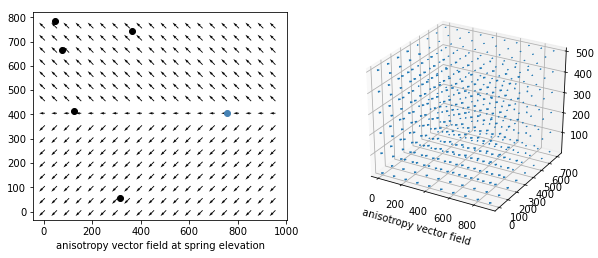

In [21]:
#Set anisotropy field:
#Must be opposite direction - will be reversed in the algorithm

#Use stacked arrays of the topography at the contact between limestone and shale:
V = np.repeat(zcontact[:,:,np.newaxis], zres, axis=2)  #create a 3D array where elevation array is repeated on each layer
DxV,DyV,DzV = np.gradient(V, dx,dy,dz, axis=(0,1,2))   #x and y components of gradient in each cell of array 

#Assign position-dependent cost?
run=True
if run:
    alpha = np.full(V.shape,   0.2) #set up array of default alpha values
    alpha[np.isnan(geocrop)] = 0.9  #assign high cost to areas outside model boundary (nan)
    alpha[geocrop==1]        = 0.1  #assign low cost to limestone (1)
    alpha[geocrop==2]        = 0.6  #assign medium-high cost to shale (2)
    beta  = np.full(V.shape,   0.8) #set up array of default beta values
    beta[np.isnan(geocrop)]  = 0.9  #assign high cost to areas outside model boundary
    beta[geocrop==1]         = 0.3  #assign low cost to limestone
    beta[geocrop==2]         = 0.8  #assign medium-high cost to shale
    
#Assign uniform cost:
run=False
if run:
    alpha = 0.2      #travel cost parallel to vector direction (0.2)
    beta  = 0.8      #travel cost orthogonal to vector direction (0.8)
    
F = Riemann.needle([DxV,DyV,DzV], alpha,beta)  #convert gradient fields to hfm format & incorporate travel costs
hfmIn['metric']    =  F                        #assign to model

#Plot anisotropic vector field (2D cross-section):
f = plt.figure(figsize=(10,4))
ax = f.add_subplot(1,2,1)
ax.set_aspect('equal')
ax.set_xlabel('anisotropy vector field at spring elevation')
subsample=(5,5)      #subsample every nth point to make plot less crowded
ax.quiver(ss(X[:,:,ispring[2]],subsample),ss(Y[:,:,ispring[2]],subsample), 
          ss(DxV[:,:,ispring[2]],subsample),ss(DyV[:,:,ispring[2]],subsample))
ax.scatter(springXYZ[0],springXYZ[1],c='steelblue')
ax.scatter(tips[:,0],tips[:,1],c='k')

#Plot in 3D:
ax = f.add_subplot(1,2,2, projection='3d')
ax.set_xlabel('anisotropy vector field')
subsample=(10,10,10)      #subsample every nth point to make plot less crowded
ax.quiver(ss(X,subsample),ss(Y,subsample),ss(Z,subsample), 
          ss(DxV,subsample),ss(DyV,subsample),ss(DzV,subsample), length=100) 

In [22]:
#Select desired outputs and run model:
hfmIn['exportValues'] = 1
hfmIn['exportGeodesicFlow'] = 1

hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 1.492 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


In [23]:
#Export resulting conduit paths for ParaView:
paths = hfmOut['geodesics']
pathsa = np.concatenate(paths, axis=1)                   #concatenate into array
pathsdf = pd.DataFrame(pathsa, index=['x','y','z'], columns=np.arange(pathsa.shape[1])).T
pathsdf.to_csv('paths.csv',header=True,index=False)       #export to csv for ParaView

#### View results ####
For best visualization, use ParaView

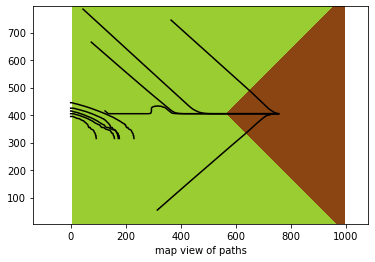

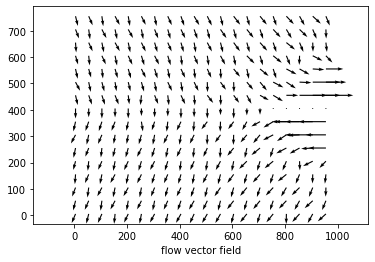

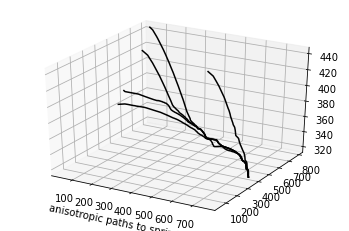

In [24]:
#Plot cross-section of results:
#Note: there is an error in plotting the paths in 2D - ignore squiggly disconnected lines
plt.figure()
plt.xlabel('map view of paths')
plt.axis('equal')
plt.contourf(X[:,:,ispring[2]],Y[:,:,ispring[2]],geomap, cmap=cmap, vmin=0,vmax=2) #travel cost
paths = hfmOut['geodesics']
for path in paths:  #loop over paths (one per tip/starting point)
    pathX = path[0,:]             #get list of X coord
    pathY = path[1,:]
    plt.plot(*path, c='k')

#Plot flow field:
plt.figure();
plt.xlabel('flow vector field')
plt.axis('equal')
quiver(X[:,:,ispring[2]],Y[:,:,ispring[2]], *hfmOut['flow'][[1,2],:,:,ispring[2]], subsampling=(5,5))

#Plot results in 3D:
ax = plt.figure().gca(projection='3d')
ax.set_xlabel('anisotropic paths to spring')
for path in paths:  #loop over paths (one per tip/starting point)
    pathX = path[0,:]             #get list of X coord
    pathY = path[1,:]
    pathZ = path[2,:]
    plt.plot(*path, c='k')

In [160]:
#Plot in Mayavi pop-up window:
#Travel time:
contours = np.linspace(np.min(hfmOut['values']), np.max(hfmOut['values']), num=10).tolist() #generate contours
values = hfmOut['values'] #get travel time values
values[np.isinf(values)] = np.nan #remove infinite values
mlab.contour3d(X,Y,Z, values, contours=contours, opacity=0.25)

#Cost:
#contours = np.linspace(np.min(hfmIn['cost']), np.max(hfmIn['cost']), num=2).tolist() #generate contours
#mlab.contour3d(X,Y,Z, hfmIn['cost'], contours=contours)  #plot travel time

#Plot land surface:
#mlab.surf(X[:,:,0],Y[:,:,0], dema, colormap='gray')
#Plot contact surface:
mlab.surf(X[:,:,0],Y[:,:,0], zcontact, colormap='gray', opacity=0.5)

#Shortest paths:
for path in hfmOut['geodesics']:  #loop over paths (one per tip/starting point)
    pathX = path[0,:]             #get list of X coord
    pathY = path[1,:]
    pathZ = path[2,:]
    mlab.plot3d(pathX,pathY,pathZ, color=(0,0,0), tube_radius=1) #plot paths
mlab.plot3d([0,0],[400,400],[500,600], color=(0,0,0), tube_radius=1*dx)  #plot short vertical line at upper western midline of area

mlab.show() # Displays in an external window. 


### Old/extra snippets ###

In [7]:
#WITHOUT SPRING ITERATION:
#Create model object:
hfmIn = Eikonal.dictIn({
    'model':             'Riemann3', #three-dimensional Riemannian eikonal equation (for 2D: Riemann2, for isotropic: Isotropic2 or 3)
    'order':              2,         #recommended setting: 2
    'exportValues':       1,         #output travel time field
    'exportGeodesicFlow': 1          #output walker paths
})

# Define the domain and get a coordinate system
hfmIn.SetRect(sides=[[xmin,xmax],[ymin,ymax],[zmin,zmax]],dims=[xres,yres,zres])

#Assign springs (ending points for walkers):
hfmIn['seed'] = springXYZ

#Loop over inlets/tips, run algorithm, and update the travel cost in cells traversed by paths
#Cells with a path should have lower travel cost
Cratio = 0.25                       #ratio of travel cost parallel to gradient / perpendicular to gradient
network = []
for tip in tips:
    hfmIn['tips'] = [tip]
    print('starting point:', hfmIn['tips'])
    #Set anisotropy field (use opposite direction - will be reversed by the algorithm)
    V = np.repeat(dema[:,:,np.newaxis], zres, axis=2)  #create a 3D array where elevation array is repeated on each layer
    DxV,DyV,DzV = np.gradient(V, dx,dy,dz, axis=(0,1,2))   #x and y components of gradient in each cell of array 

    #Assign position-dependent travel cost:
    alpha = cost             #travel cost in same direction as gradient
    beta  = alpha / Cratio   #travel cost perpendicular to gradient (should be higher than parallel cost) 
    F = Riemann.needle([DxV,DyV,DzV], alpha,beta)  #convert gradient fields to hfm format & incorporate travel costs
    hfmIn['metric']    =  F                        #assign to model
    
    #Run model:
    hfmOut = hfmIn.Run()
    
    #Get & store resulting paths:
    paths = hfmOut['geodesics']
    network.append(paths)          #store current iteration's paths in list of all paths in network
    for path in paths:                     #loop over paths (if more than one per iteration)
        for i in range(path.shape[1]):     #loop over XYZ coordinates of each point in path (have to index to loop over second dimension)
            point = path[:,i]          
            [[ix,iy,iz],error] = hfmIn.IndexFromPoint(point) #convert to indices
            cost[ix,iy,iz] = Cconduit   #assign a new cost value to cells with conduits in them
#print(np.unique(cost))  #debugging check

starting point: [[285. 765. 415.]]
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 1.492 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
starting point: [[155. 375. 395.]]
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 1.635 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
starting point: [[595. 635. 375.]]
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 1.511 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
starting point: [[325. 715. 405.]]
Field verbosity defaults to 1
Field